In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pylab import *
from IPython.display import display

# 加载数据
# 数据：抽样一小时（2017031217）的行为数据，关联当天（20170312）所有阅读时长上报日志
file_name = 'data/tmp_hindi_app_iflow_reco_pv_rd_2017031217' # 'data/tmp_hindi_app_iflow_reco_pv_rd_2017030117'
columns = '''tm_pv,reco_id,ds,item_id,app,set_lang,cate,item_type,tm_rd,tm_vl,is_rf,clk,pub_tm,upd_tm,len,tm_clk'''.split(",")
data = pd.read_csv(file_name, sep='\1', header=None, names=columns, dtype={'cate':str})

print(data.dtypes)
print(data.shape)
print(data.index)
print(data.columns)

# 数据case
data.head(5)

tm_pv         int64
reco_id      object
ds           object
item_id       int64
app          object
set_lang     object
cate         object
item_type     int64
tm_rd        object
tm_vl        object
is_rf        object
clk           int64
pub_tm        int64
upd_tm        int64
len           int64
tm_clk       object
dtype: object
(1035361, 16)
RangeIndex(start=0, stop=1035361, step=1)
Index([u'tm_pv', u'reco_id', u'ds', u'item_id', u'app', u'set_lang', u'cate',
       u'item_type', u'tm_rd', u'tm_vl', u'is_rf', u'clk', u'pub_tm',
       u'upd_tm', u'len', u'tm_clk'],
      dtype='object')


,tm_pv,reco_id,ds,item_id,app,set_lang,cate,item_type,tm_rd,tm_vl,is_rf,clk,pub_tm,upd_tm,len,tm_clk
0,1489312596,30835857-a1fd-4bf9-a9f4-8a5e33281c30,WKjkrQteOkIDAK0mKrpIcHWg,1005364371572074,app_iflow,hindi,025,201,\N,\N,\N,0,1489151046,1489288318,423,\N
1,1489309224,5cfcc594-37fe-4b0e-aea1-8913a0e96279,WLd6Q+oaTtIDAB/l4kQhvpeI,1005364371572074,app_iflow,hindi,025,201,\N,\N,\N,0,1489151046,1489288318,423,\N
2,1489312545,b93617d0-ad31-4ea2-8d59-fae97700452a,WMPJH/0KB3sDAFCUcq5d2AvG,1005364371572074,app_iflow,hindi,025,201,1489333815,17970,0,1,1489151046,1489288318,423,1489312783
3,1489309825,4f3778e7-a0a2-4881-9fbd-72c28204e150,V4pXSYWI244DAOCHtcZdywft,1005364371572074,app_iflow,hindi,025,201,\N,\N,\N,0,1489151046,1489288318,423,\N
4,1489309329,08c65ebb-54ad-4d17-8f6f-c82170722fa9,WLaO1+AB9t8DAHw1/fOvBSuD,1005364371572074,app_iflow,hindi,025,201,\N,\N,\N,0,1489151046,1489288318,423,\N


In [47]:
# 数据描述 - 总体
data.describe()

# 覆盖
pv = data['tm_pv'].count()

def cover(vs):
    cnt = 0
    for v in vs:
        if isinstance(v, str) and v == '\\N':
            continue
        cnt += 1
    return cnt

# 结论：点击阅读时长上报覆盖率约45%
cover_stat = data[data['clk']==1][['clk','tm_vl','is_rf']].groupby(data['clk']).agg(cover)
clk_num = cover_stat['clk'].values[0]
rd_num = cover_stat['tm_vl'].values[0]
ctr = float(clk_num)/pv
cover_rd = float(rd_num)/clk_num
print pv,clk_num,rd_num,ctr,cover_rd

1035361 75560 34465 0.0729793762755 0.456127580731


In [156]:
# --------- 数据清洗 ----------
# 数据清洗，空值过滤，只考虑有点击和时长上报的样本
# dc = data[(data['tm_vl'].str.contains('\\N')==False)]
dc = data[(data['tm_vl'].str.contains('\\N')==False)&(data['tm_clk'].str.contains('\\N')==False)]
print dc.shape

# 异常值过滤
def abnorm_filter(df, column, th=0.95):
    lower = 0
    upper = df[column].quantile(th)
    return df[(df[column]<upper) & (df[column]>lower)]

dc['tm_vl'] = dc['tm_vl'].apply(pd.to_numeric) # 阅读时长
dc = abnorm_filter(dc, 'tm_vl', 0.95)
print dc.shape

dc['tm_rd'] = dc['tm_rd'].astype('float')
dc['is_rf'] = dc['is_rf'].astype('float')
dc['tm_clk'] = dc['tm_clk'].astype('float')

dc['td_clk'] = dc['tm_clk']-dc['tm_pv']
dc['td_rd'] = dc['tm_rd']-dc['tm_pv']

(34465, 16)
(32740, 16)


/home/datamining/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,td_clk,td_rd,tm_vl,len,is_rf
count,32740.000000,32740.000000,32740.000000,32740.000000,32740.000000
mean,364.784209,5893.818235,39863.858888,2710.462187,0.371717
std,1035.857181,6661.071108,36581.806247,6444.341026,0.483271
min,0.000000,21.000000,1.000000,0.000000,0.000000
25%,27.000000,915.000000,10766.000000,985.000000,0.000000
50%,84.000000,2436.000000,29155.000000,1608.000000,0.000000
75%,241.000000,9446.000000,59802.500000,2292.000000,1.000000
max,10753.000000,24997.000000,158902.000000,157008.000000,1.000000


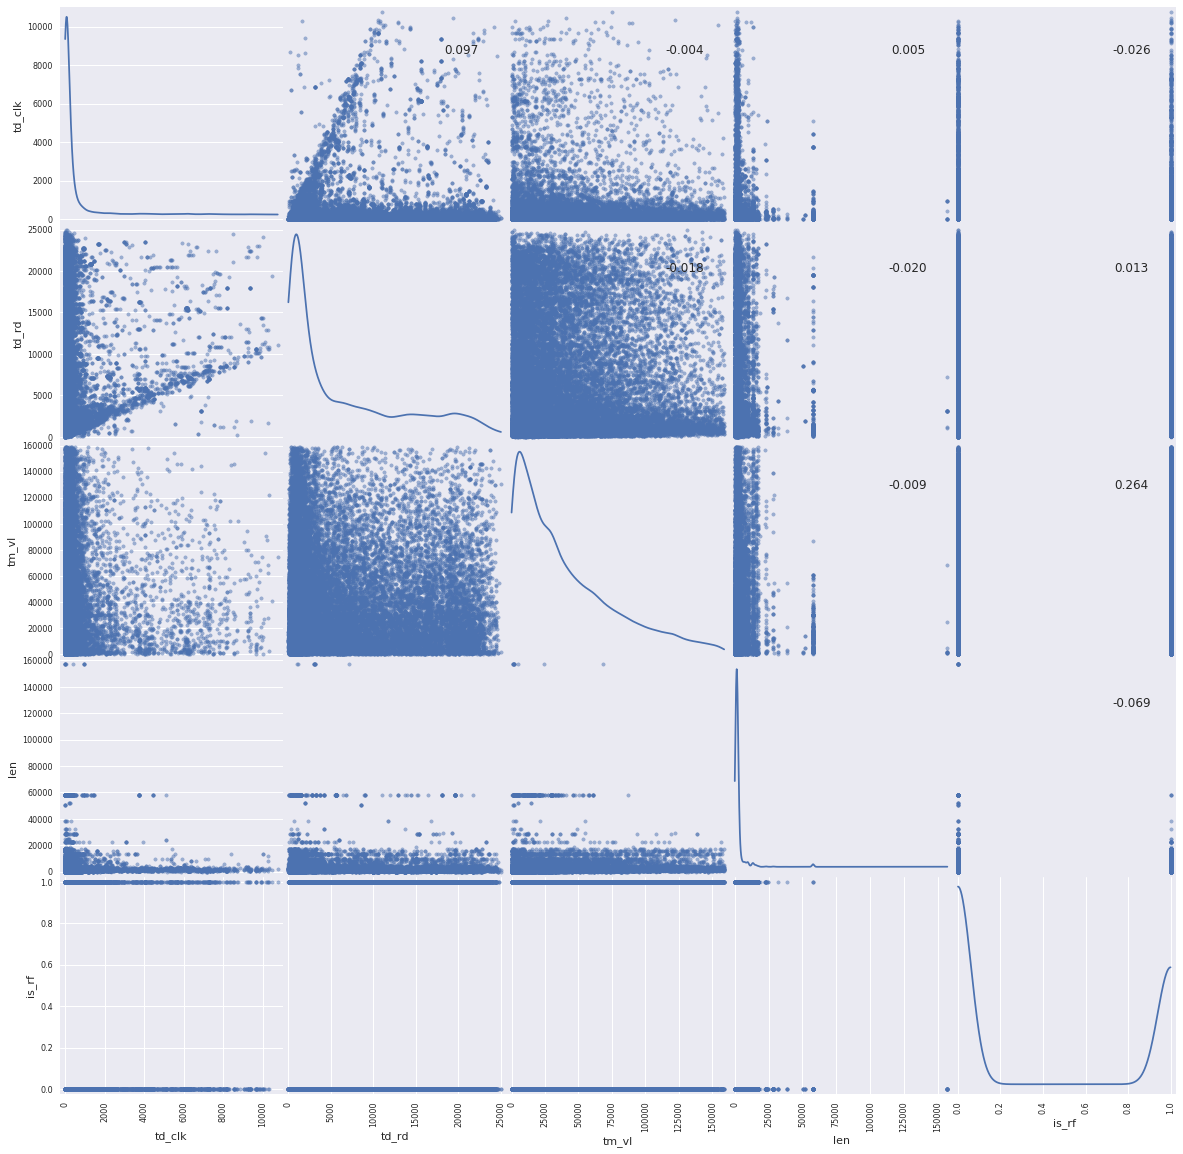

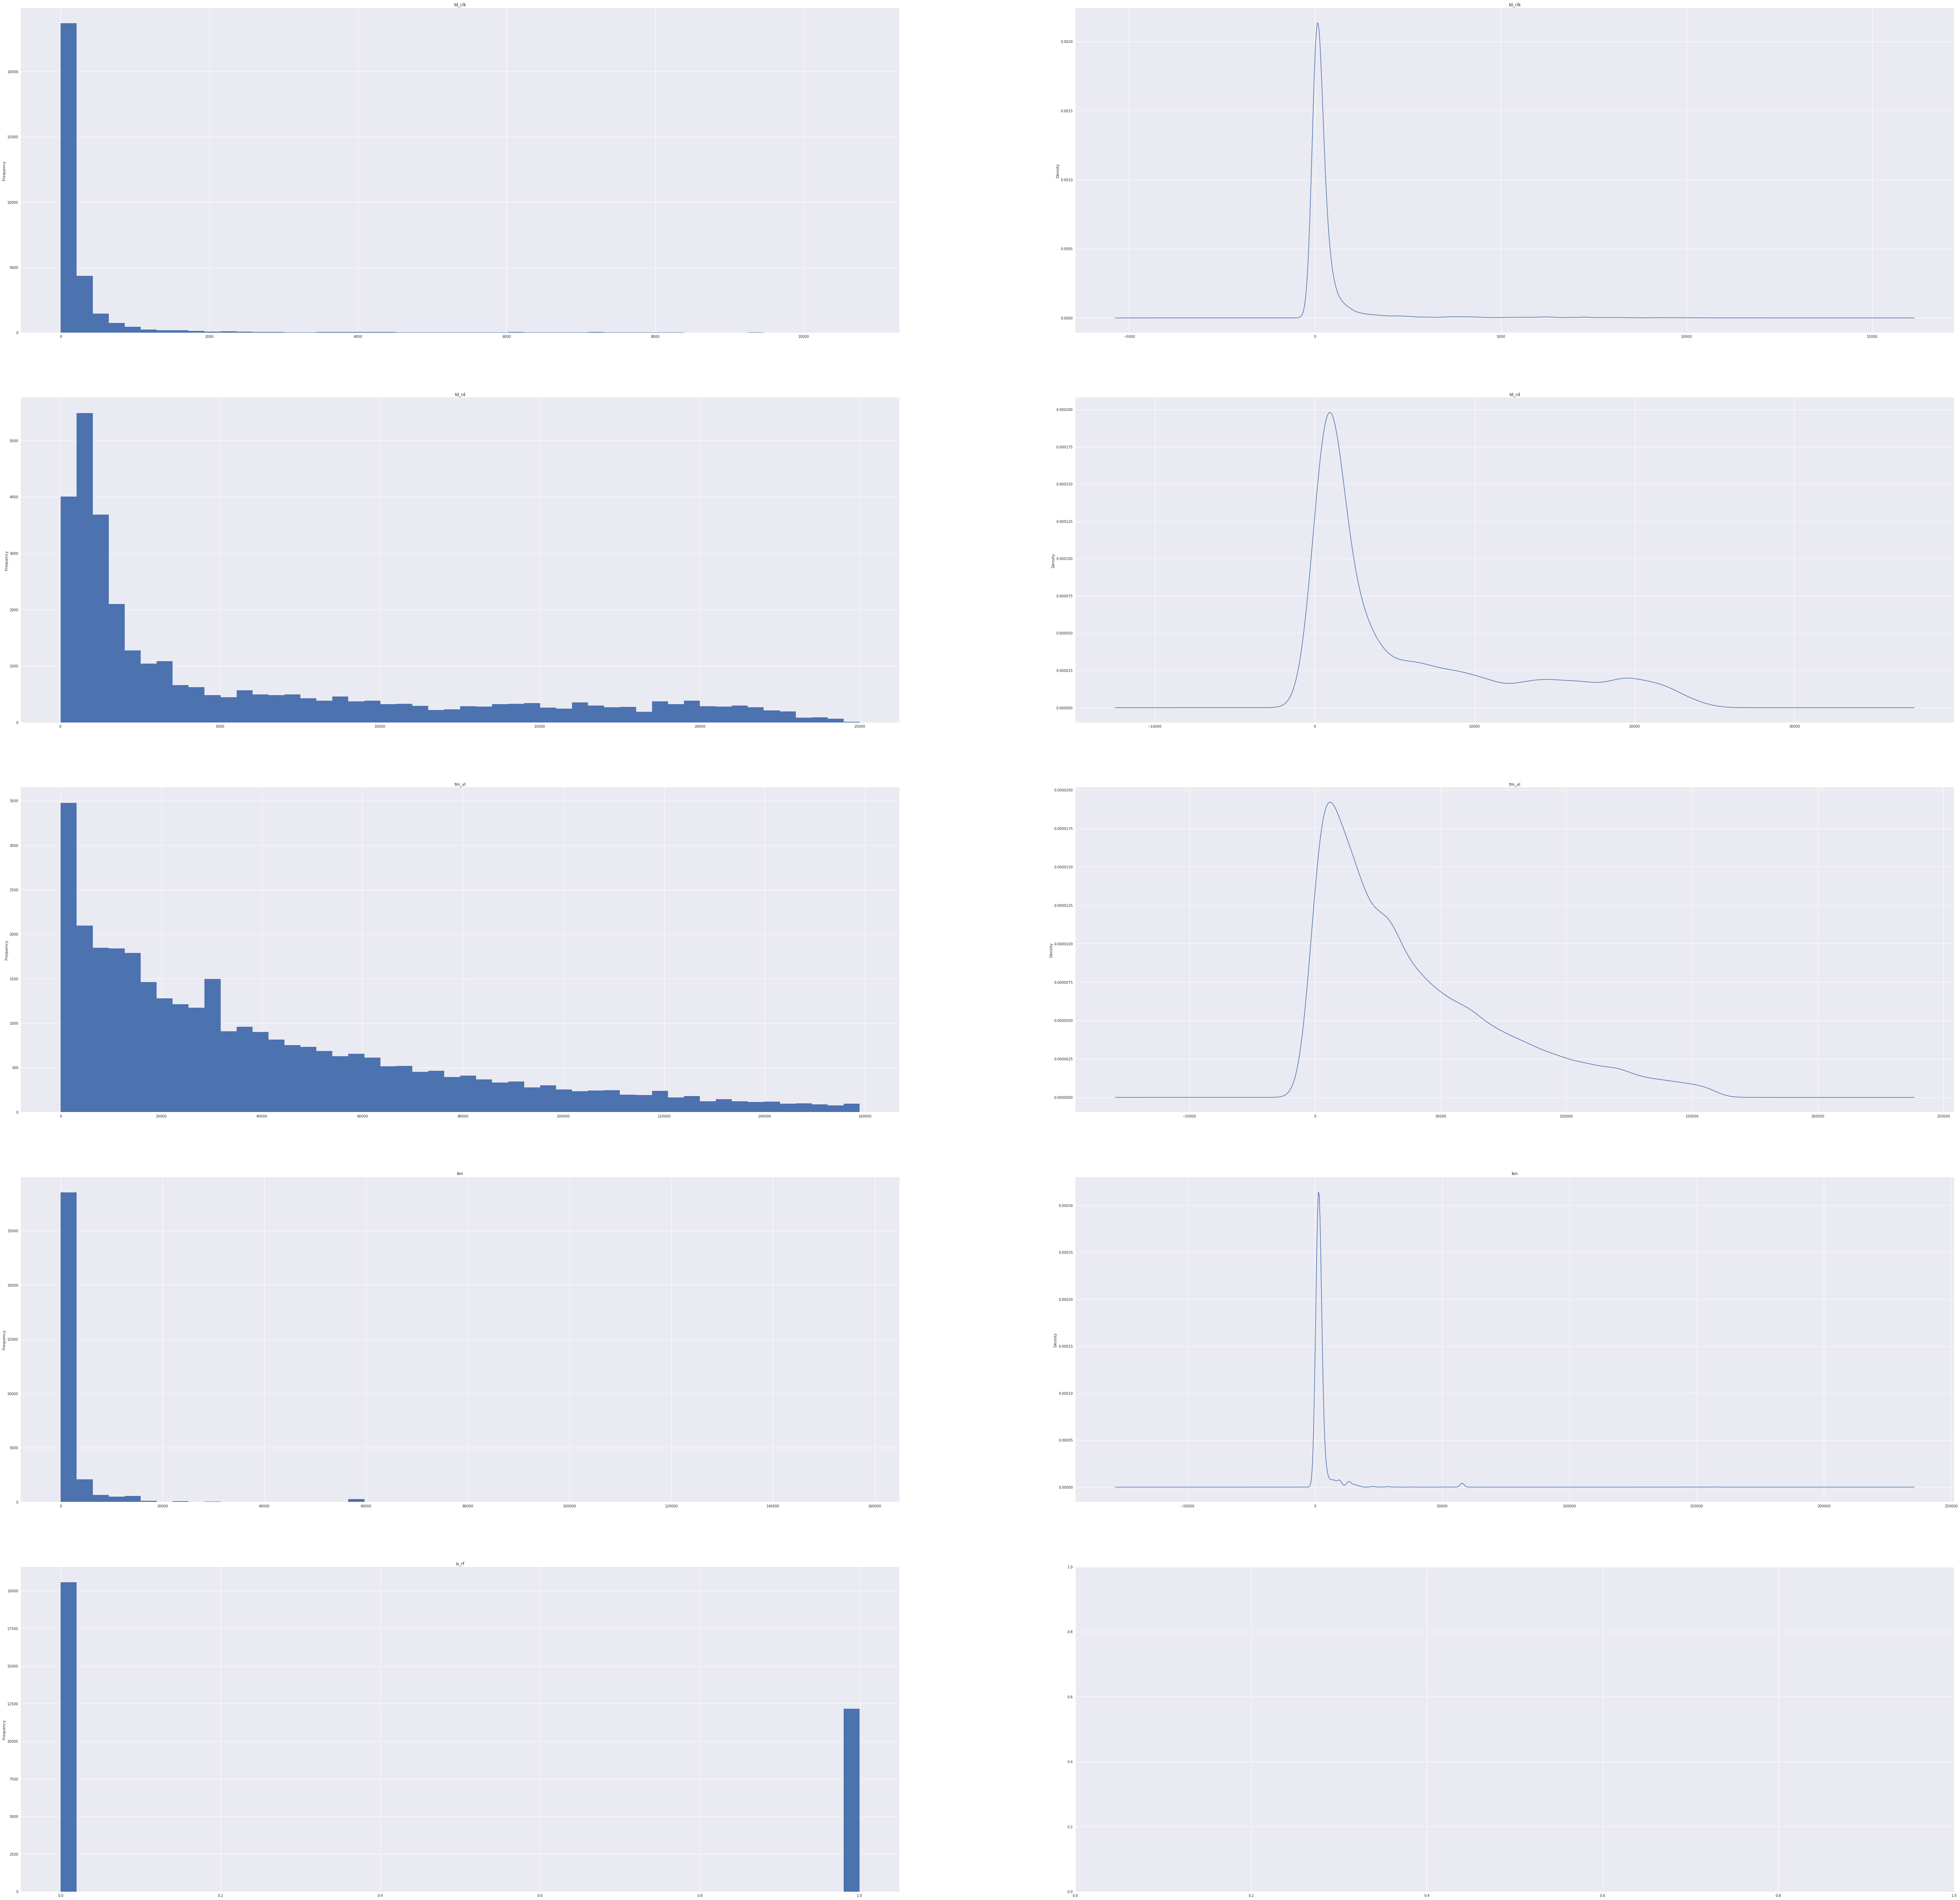

In [67]:
# ----------- 数据描述 -----------
cols = ['td_clk','td_rd','tm_vl','len','is_rf']

# ------------------
# 基本统计量
# ------------------
display(dc[cols].describe())

# ------------------
# 数据分布
# ------------------
# 散点图矩阵
axes = pd.scatter_matrix(dc[cols], alpha=0.5, figsize=(20,20), diagonal='kde')
corr = dc[cols].corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f"%corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

# 直方图分布、概率密度估计
cols_num = len(cols)
fig, axes = plt.subplots(nrows=cols_num, ncols=2)
figsize = (100,100)
bins = 50
for i in range(0, cols_num):
    col = cols[i]
    dc[col].plot(kind='hist', bins=bins, figsize=figsize, ax=axes[i, 0], title=col)
    if col in set(['td_clk', 'td_rd', 'tm_vl', 'len']):
        dc[col].plot(kind='kde', figsize=figsize, ax=axes[i, 1], title=col)
plt.show()

In [142]:
cate_dist = dc[(dc['cate'].str.len()==3)&(dc['cate'].str.startswith('032')==False)][['cate','tm_vl']].groupby('cate').count()
cate_set = set(cate_dist[cate_dist['tm_vl']>100].index)
dc_cate_tm_vl_len = dc[['cate','tm_vl','len']][dc[['cate','tm_vl','len']].apply(lambda x: x['cate'] in cate_set, axis=1)]
dc_cate_tm_vl_len.groupby('cate').corr()

# dc_cate_tm_vl_len = dc[(dc['cate'].str.len()==3)&(dc['cate'].str.startswith('032')==False)&(dc['len']<dc['len'].quantile(0.95))][['cate','tm_vl','len']]
# dc_cate_tm_vl_len.groupby('cate').corr()


len     tm_vl
cate                          
001  len    1.000000 -0.098452
     tm_vl -0.098452  1.000000
002  len    1.000000  0.091347
     tm_vl  0.091347  1.000000
004  len    1.000000  0.049208
     tm_vl  0.049208  1.000000
005  len    1.000000  0.085610
     tm_vl  0.085610  1.000000
006  len    1.000000  0.020401
     tm_vl  0.020401  1.000000
008  len    1.000000  0.088382
     tm_vl  0.088382  1.000000
010  len    1.000000  0.121415
     tm_vl  0.121415  1.000000
011  len    1.000000  0.158625
     tm_vl  0.158625  1.000000
012  len    1.000000  0.047301
     tm_vl  0.047301  1.000000
013  len    1.000000  0.135527
     tm_vl  0.135527  1.000000
014  len    1.000000  0.195075
     tm_vl  0.195075  1.000000
015  len    1.000000 -0.012830
     tm_vl -0.012830  1.000000
016  len    1.000000 -0.046270
     tm_vl -0.046270  1.000000
018  len    1.000000 -0.056320
     tm_vl -0.056320  1.000000
021  len    1.000000  0.008776
     tm_vl  0.008776  1.000000
023  len    1.000000  0.143291
     tm_vl  0.143291  1.000000
025  len    1.000000  0.241360
     tm_vl  0.241360  1.000000
026  len    1.000000 -0.084219
     tm_vl -0.084219  1.000000

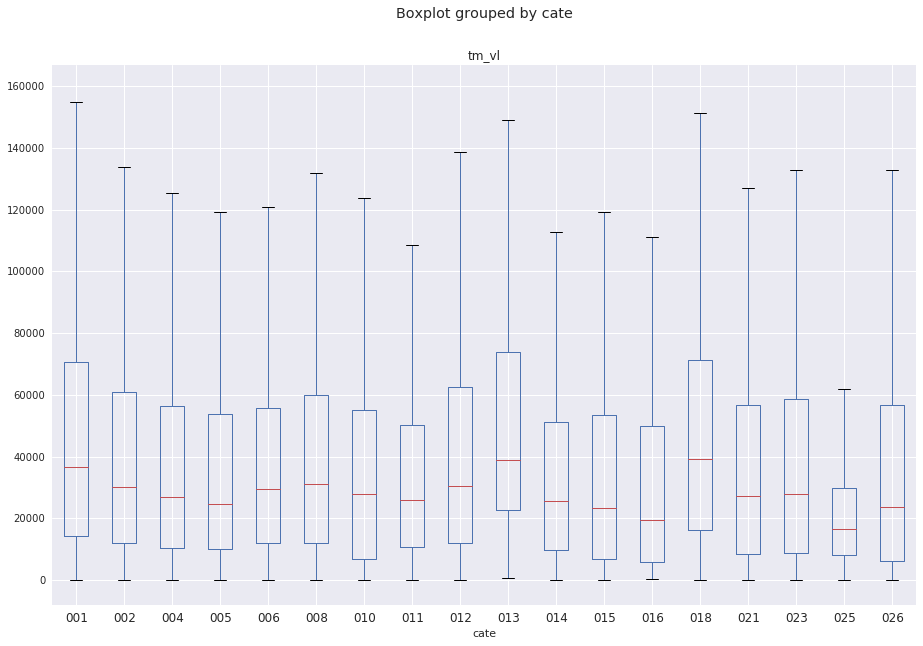

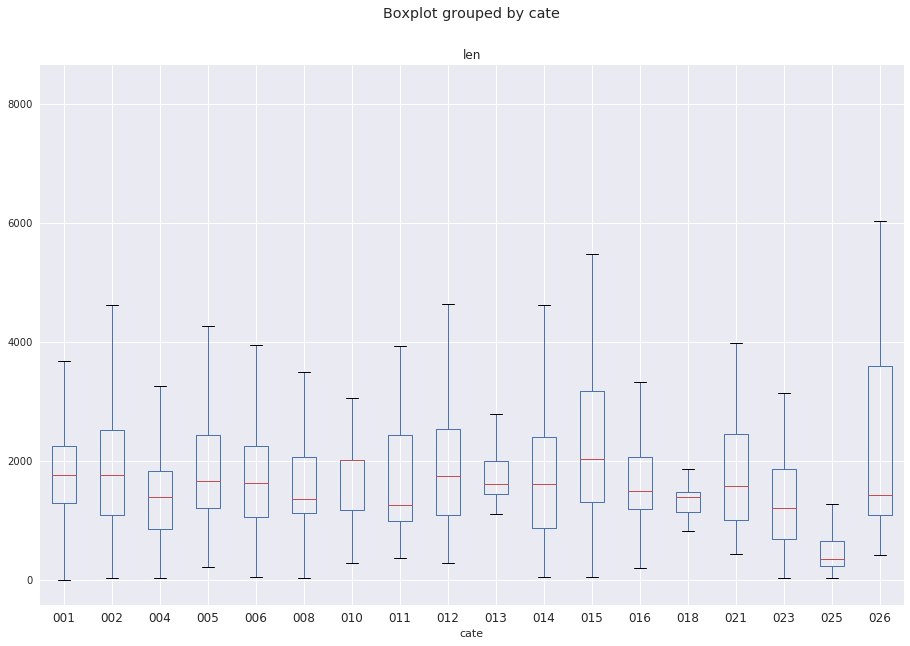

,tm_vl,len
tm_vl,1.00000,0.56774
len,0.56774,1.00000


,tm_vl,len
tm_vl,1.000000,-0.009476
len,-0.009476,1.000000


,tm_vl,len
tm_vl,1.000000,0.137454
len,0.137454,1.000000


,tm_vl,len
tm_vl,1.000000,0.260715
len,0.260715,1.000000


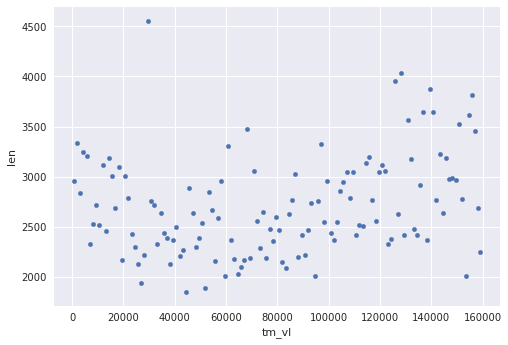

,tm_vl,len
tm_vl,1.000000,-0.083053
len,-0.083053,1.000000


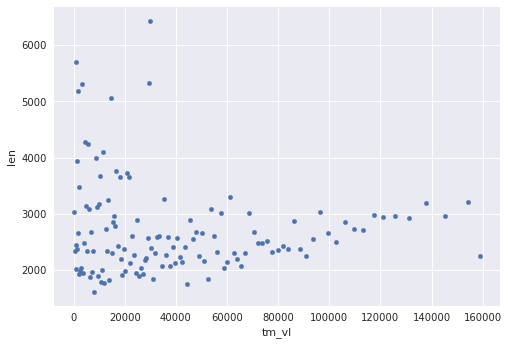

,len,tm_vl
len,1.000000,-0.520684
tm_vl,-0.520684,1.000000


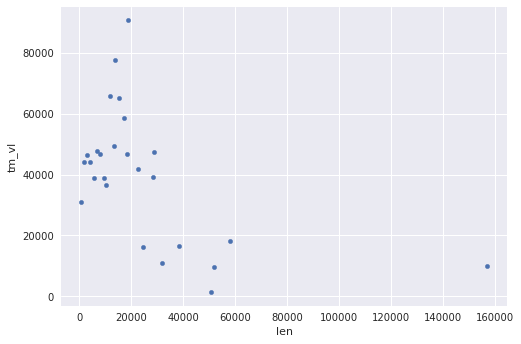

,len,tm_vl
len,1.000000,-0.246204
tm_vl,-0.246204,1.000000


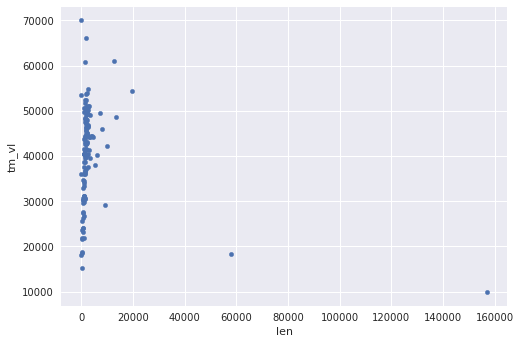

In [157]:
# ----------- 数据探索 -----------
# utils
def binary_search_range(v, lst, lower, upper):
    mid = int((lower+upper)/2)
    if abs(v-lst[mid])<1e-6:
        return [mid, min(mid+1, len(lst)-1)]
    if lower == upper:
        return [-1, -1]
    if v > lst[mid]:
        lower_nxt = int(mid+1)
        if v < lst[lower_nxt]: return [lower_nxt-1, lower_nxt]
        else: lower = lower_nxt
    if v < lst[mid]:
        upper_nxt = int(mid)
        if v > lst[upper_nxt]: return [upper_nxt, upper_nxt+1]
        else: upper = upper_nxt
    return binary_search_range(v, lst, lower, upper)

def div_bucket(x,dp):
    return [binary_search_range(v, dp, 0, len(dp)-1)[0] for v in x]

def analy_group_corr(df, c1, c2, bucket_col='c1', bucket_type='dist', bucket_num=32):
    if bucket_col != "c1":
        tmp = c1
        c1 = c2
        c2 = tmp
    ps = np.linspace(start=0, stop=1, num=bucket_num) 
    ef = dc[c1].quantile(ps).values # 等频
    ed = np.linspace(start=dc[c1].min(), stop=dc[c1].max(), num=bucket_num) # 等距
    dp = ed if bucket_type=='dist' else ef
    dc_grp = dc[[c1,c2]].groupby(div_bucket(dc[c1].values, dp))
    dc_mean = dc_grp.mean()
#     display(dc_mean)
    display(dc_mean.corr())
    dc_mean.plot(kind='scatter', x=c1, y=c2)
    plt.show()

# 类目白名单
cate_dist = dc[(dc['cate'].str.len()==3)&(dc['cate'].str.startswith('032')==False)][['cate','tm_vl']].groupby('cate').count()
cate_set = set(cate_dist[cate_dist['tm_vl']>100].index)
    
# 相关性 - 分类 vs. 阅读时长 
# plt.figure(figsize=(20, 10))
# sns.boxplot(x='cate', y='tm_vl', data=dc[dc['cate'].str.len()==3][['cate','tm_vl']])
# sns.despine(offset=10, trim=True)
dc_cate_rd_len = dc[['cate','tm_vl','len']]
dc_cate_rd_len = dc_cate_rd_len[(dc_cate_rd_len['len']<dc_cate_rd_len['len'].quantile(0.95))&dc_cate_rd_len.apply(lambda x: x['cate'] in cate_set, axis=1)]
dc_cate_rd = dc_cate_rd_len[['cate','tm_vl']]
dc_cate_rd.boxplot(column='tm_vl', by='cate', figsize=(15,10))
plt.show()

# 相关性 - 分类 vs. 内容长度分布
# plt.figure(figsize=(20, 10))
# sns.boxplot(x='cate', y='len', data=dc[(dc['cate'].str.len()==3)&(dc['len']<dc['len'].quantile(0.95))][['cate','len']])
# sns.despine(offset=10, trim=True)
# dc[(dc['cate'].str.len()==3)&(dc['len']<dc['len'].quantile(0.95))][['cate','len']].boxplot(column='len', by='cate', figsize=(15,10))
dc_cate_len = dc_cate_rd_len[['cate','len']]
dc_cate_len.boxplot(column='len', by='cate', figsize=(15,10))
plt.show()

# 相关性 - 分类分组，阅读时长和内容长度相关性
# 注：032是纯视频，没有文本内容长度，计算相关性时需要过滤掉
# 结论：呈强相关性（0.56）
dc_cate_rd_len_mean = dc_cate_rd_len.groupby('cate').mean()
# display(dc_cate_rd_len_mean.sort_values(by='tm_vl',ascending=True))
display(dc_cate_rd_len_mean.corr())
    
# 相关性 - 阅读时长 vs. 内容长度，微观，(reco_id, item_id)分组
# display(dc[(dc['len']>0)&(dc['len']<dc['len'].quantile(0.95))][['tm_vl','len']].corr('spearman'))
# 结论：不对len过滤，不相关（-0.009）；对len按0.95分位数过滤，弱相关（0.13）
display(dc[['tm_vl','len']].corr())
display(dc[['tm_vl','len']][dc['len']<dc['len'].quantile(0.95)].corr())

# 相关性 - 阅读时长 vs. 内容长度，宏观，按阅读时长等距分组
analy_group_corr(dc, 'tm_vl', 'len', bucket_col='c1', bucket_type='dist', bucket_num=128)

# 相关性 - 阅读时长 vs. 内容长度，宏观，按阅读时长等频分组
analy_group_corr(dc, 'tm_vl', 'len', bucket_col='c1', bucket_type='freq', bucket_num=128)

# 相关性 - 阅读时长 vs. 内容长度，宏观，按内容长度等距分组
analy_group_corr(dc, 'tm_vl', 'len', bucket_col='c2', bucket_type='dist', bucket_num=128)

# 相关性 - 阅读时长 vs. 内容长度，宏观，按内容长度等频分组
analy_group_corr(dc, 'tm_vl', 'len', bucket_col='c2', bucket_type='freq', bucket_num=128)

    
# ps = np.linspace(start=0, stop=1, num=33) 
# ef = dc['tm_vl'].quantile(ps).values
# dc_grp = dc[['tm_vl','len']].groupby(div_bucket(dc['tm_vl'].values, ef))
# dc_mean = dc_grp.mean()
# display(dc_mean)
# display(dc_mean.corr())
# dc_mean.plot(kind='scatter', x='len', y='tm_vl')
# plt.show()

In [99]:
import hashlib

print hash('ds')

12800076900115549


In [95]:
import hashlib

display(dc[['tm_vl','len']].corr())

display(dc[(dc['len']<dc['len'].quantile(0.95))][['tm_vl','len']].corr())

dc_cate_tm_vl_len_mean = dc[(dc['len']<dc['len'].quantile(0.95))][['item_id','tm_vl','len']].groupby('item_id').mean()
display(dc_cate_tm_vl_len_mean.corr())

dc_cate_tm_vl_len_mean = dc[(dc['len']<dc['len'].quantile(0.95))][['ds','tm_vl','len']].groupby('ds').mean()
display(dc_cate_tm_vl_len_mean.corr())

dc_cate_tm_vl_len_mean = dc[(dc['cate'].str.len()==3)&(dc['len']<dc['len'].quantile(0.95))][['cate','tm_vl','len']].groupby('cate').mean()
display(dc_cate_tm_vl_len_mean.corr())

def hash_id(vs, buckets):
    return [str(hash(v)%buckets) for v in vs]

# ddc = dc[(dc['len']<dc['len'].quantile(0.95))][['ds','tm_vl','len']]
# dc_cate_tm_vl_len_mean = ddc.groupby(hash_id(ddc['ds'].values, 10))['tm_vl', 'len'].mean()
# display(dc_cate_tm_vl_len_mean.corr())

dc_cate_tm_vl_len_mean = dc[(dc['len']<dc['len'].quantile(0.95))][['ds','tm_vl','len']].groupby(hash_id(ddc['ds'].values, 10))['tm_vl', 'len'].mean()
display(dc_cate_tm_vl_len_mean.corr())

dc_cate_tm_vl_len_mean = dc[(dc['len']<dc['len'].quantile(0.95))][['ds','tm_vl','len']].groupby(hash_id(ddc['ds'].values, 100))['tm_vl', 'len'].mean()
display(dc_cate_tm_vl_len_mean.corr())

dc_cate_tm_vl_len_mean = dc[(dc['len']<dc['len'].quantile(0.95))][['ds','tm_vl','len']].groupby(hash_id(ddc['ds'].values, 1000))['tm_vl', 'len'].mean()
display(dc_cate_tm_vl_len_mean.corr())


,tm_vl,len
tm_vl,1.000000,-0.009476
len,-0.009476,1.000000


,tm_vl,len
tm_vl,1.000000,0.137454
len,0.137454,1.000000


,tm_vl,len
tm_vl,1.000000,0.175687
len,0.175687,1.000000


,tm_vl,len
tm_vl,1.000000,0.088759
len,0.088759,1.000000


,tm_vl,len
tm_vl,1.000000,0.237906
len,0.237906,1.000000


,tm_vl,len
tm_vl,1.00000,0.54942
len,0.54942,1.00000


,tm_vl,len
tm_vl,1.000000,0.022175
len,0.022175,1.000000


,tm_vl,len
tm_vl,1.000000,0.115938
len,0.115938,1.000000


In [ ]:
# ----------- 数据探索 -----------
# 微观相关性分析
display(dc[cols].corr())


# 1. 数据描述
# 统计量
display(dc.describe())

# 数据分布
# pd.scatter_matrix(dc, )

# 阅读时长分布
# figsize(1, 2)
# dc['tm_vl'].plot(kind='hist', bins=50)
dc['tm_vl'].plot(kind='kde')
show()



# 

# 2. 数据探索
# 相关系数
dd = dc[['tm_vl','is_rf','clk','len']]
# display(dd.corr()) # pearson,spearman,kendell
display(dd.corr('spearman')) # pearson,spearman,kendell
display(dd.cov())

# pd.scatter_matrix(dd, alpha=0.2, figsize=(6,6), diagonal='kde')
# show()

# 阅读时长分布
dc['tm_vl'].plot(kind='kde')
show()

# 阅读时长 vs. 文章长度
# 1）从微观上看，阅读时长和文章长度呈弱相关，无论文章长度，大部分阅读时长都集中在底部，只是文章越长，头部阅读时长也会慢慢增加，但不是主导作用。
# 2）从宏观上看，平均阅读时长和平均文章长度呈强正相关，随着文章平均长度的增加，平均阅读时长也会增加
# 对于多因素相关的场景，微观相关性分析往往不能准确反应两个因素间的相关性，因为不成显著相关很可能是第三方因素的影响，比如上面的例子，很可能是类目等bias导致微观弱相关。因此，应该从宏观平均意义上加以分析，已减少第三方因素的影响。
# dd2 = dc[['tm_vl','len']]
# dd2 = dd[(dd['len']<dd['len'].quantile(0.9))&(dd['len']>dd['len'].quantile(0.05))][['tm_vl','len']]
dd2 = dc[dc['len']<dc['len'].quantile(0.95)][['tm_vl','len']]
display(dd2.corr())
dd2.plot(kind='scatter',x='len',y='tm_vl')
show()

dd2_grouped = dd2.groupby((dd2['len']/100).astype('int'))
dd2_mean = dd2_grouped.mean()
display(dd2_mean.corr('spearman'))
dd2_mean.plot(kind='scatter',x='tm_vl',y='len')
show()

# 阅读时长 vs. 分类


# 阅读时长 vs. CTR
# 分组：uid，item_id，cate
dd3 = data[['ds','clk','tm_vl','tm_pv']].groupby(data['ds']).mean()
display(dd3.head(5))




In [ ]:
# 阅读时长 vs. CTR
# 分组：uid，item_id，cate

def binary_search_range(v, lst, lower, upper):
    mid = int((lower+upper)/2)
    if abs(v-lst[mid])<1e-6:
        return [mid, min(mid+1, len(lst)-1)]
    if lower == upper:
        return [-1, -1]
    if v > lst[mid]:
        lower_nxt = int(mid+1)
        if v < lst[lower_nxt]: return [lower_nxt-1, lower_nxt]
        else: lower = lower_nxt
    if v < lst[mid]:
        upper_nxt = int(mid)
        if v > lst[upper_nxt]: return [upper_nxt, upper_nxt+1]
        else: upper = upper_nxt
    return binary_search_range(v, lst, lower, upper)

def div_bucket(x,dp):
    return [binary_search_range(v, dp, 0, len(dp)-1)[0] for v in x]

def analy_group_corr_duration_ctr_div_bucket(data,group='ds',bucket_type='dist',buckets=32):
    ''' 
    分组阅读时长和ctr相关性分析
    @param group 分组，{ds, item_id, cate}
    @param bucket_type 分桶类型，{dist, freq}
    @param buckets 分桶数
    '''
    ddf = data[[group,'clk','tm_vl']].replace('\\N',{'tm_vl':None})
    ddf['tm_vl'] = ddf['tm_vl'].astype('float')
    dd3_ctr = ddf[[group,'clk']].groupby(ddf[group]).mean() # group平均ctr
#     display(dd3_ctr.head(10))
    ddf2 = ddf[(ddf['tm_vl']>0)][[group,'tm_vl']]
    ddf2 = ddf2[ddf2['tm_vl']<ddf2['tm_vl'].quantile(0.95)]
    dd3_tm_vl = ddf2.groupby(ddf2[group]).mean() # group平均阅读时长
    dd3_ctr_tm_vl = dd3_ctr.join(dd3_tm_vl)
    dd3_ctr_tm_vl = dd3_ctr_tm_vl[np.isnan(dd3_ctr_tm_vl['tm_vl'])==False]
    # group ctr和阅读时长相关性 -- 微观
    display(dd3_ctr_tm_vl.corr())
    dd3_ctr_tm_vl.plot(kind='scatter',x='tm_vl',y='clk')
    show()
    # 平均group ctr和平均group阅读时长相关性 -- 宏观
    ps = np.linspace(start=0, stop=1, num=33) 
    ef = dd3_ctr_tm_vl['tm_vl'].quantile(ps).values # 等频
    ed = np.linspace(start=dd3_ctr_tm_vl['tm_vl'].min(), stop=dd3_ctr_tm_vl['tm_vl'].max(), num=33) # 等距
    dp = ed if bucket_type=='dist' else ef
    dd3_ctr_tm_vl_grp = dd3_ctr_tm_vl.groupby(div_bucket(dd3_ctr_tm_vl['tm_vl'].values,dp))
    dd3_ctr_tm_vl_mean = dd3_ctr_tm_vl_grp.mean()
#     display(dd3_ctr_tm_vl_mean)
    display(dd3_ctr_tm_vl_mean.corr())
    dd3_ctr_tm_vl_mean.plot(kind='scatter', x='clk', y='tm_vl')
    show()
    
# user分组，阅读时长和点击率相关性
# 结论：从user分组平均角度看，呈弱正相关（0.26）
print '----------- user group ------------'
analy_group_corr_duration_ctr_div_bucket(data, group='ds')

# item分组，阅读时长和点击率相关性
# 结论：从item分组平均角度看，呈强负相关（-0.53）
print '----------- item group ------------'
analy_group_corr_duration_ctr_div_bucket(data, group='item_id')

# cate分组，阅读时长和点击率相关性
# 结论：从cate分组平均角度看，呈强正相关（0.53）
print '----------- cate group ------------'
analy_group_corr_duration_ctr_div_bucket(data, group='cate')

# display(dd3_ctr_tm_vl.head(3))
# dd3_ctr_tm_vl_grp = dd3_ctr_tm_vl.groupby(div_bucket_freq(dd3_ctr_tm_vl['clk'],dp)).astype('int')
# dd3_ctr_tm_vl_mean = dd3_ctr_tm_vl_grp.mean()
# display(dd3_ctr_tm_vl_mean)
# display(dd3_ctr_tm_vl_mean.corr('spearman'))
# dd3_ctr_tm_vl_mean.plot(kind='scatter', x='clk', y='tm_vl')
# show()

# dd3_ctr_tm_vl_grp = dd3_ctr_tm_vl[(dd3_ctr_tm_vl['tm_vl']>0)&(dd3_ctr_tm_vl['tm_vl']<dd3_ctr_tm_vl['tm_vl'].quantile(0.8))].groupby((dd3_ctr_tm_vl['clk']/5*100).astype('int'))


In [ ]:
# ----- 语法测试用 ------
# 抽取阅读时间列，过滤掉空值部分
dr = data['tm_vl'][data['tm_vl'].str.contains('\\N')==False].astype('float')

# 采样，减少计算开销
# dr = dr.sample(frac=0.2)
dr = dr.sample(n=10000)

# 异常值过滤
def abnorm_filter(ss, th=0.97):
     return ss[(ss<ss.quantile(th))&(ss>0)]
dr = abnorm_filter(dr)

# 分位数
ps = np.linspace(start=0, stop=1, num=33)
dp = dr.quantile(ps)
print dp

# 画图观察
# dr.plot(kind='hist')
# show()

dr.plot(kind='box')
show()

from pylab import *
hist(dr)
show()

cnts, bins = np.histogram(dr, bins=50, normed=True)
bins = (bins[:-1]+bins[1:])/2
plot(bins, cnts)
show()


In [ ]:
def div_bucket_len(vs):
    lst = []
    for v in vs:
        if v != '\\N':
            lst.append(str(int(v)/1000))
        else:
            lst.append(v)
    return lst

def mymean(vs):
    s = 0.0
    c = 0
    for v in vs:
        if v != '\\N':
            s += int(v)
            c += 1
    return float(s)/c if c>0 else -1.0

display(dc['len'].groupby(div_bucket_len(dc['len'])).agg(mymean))

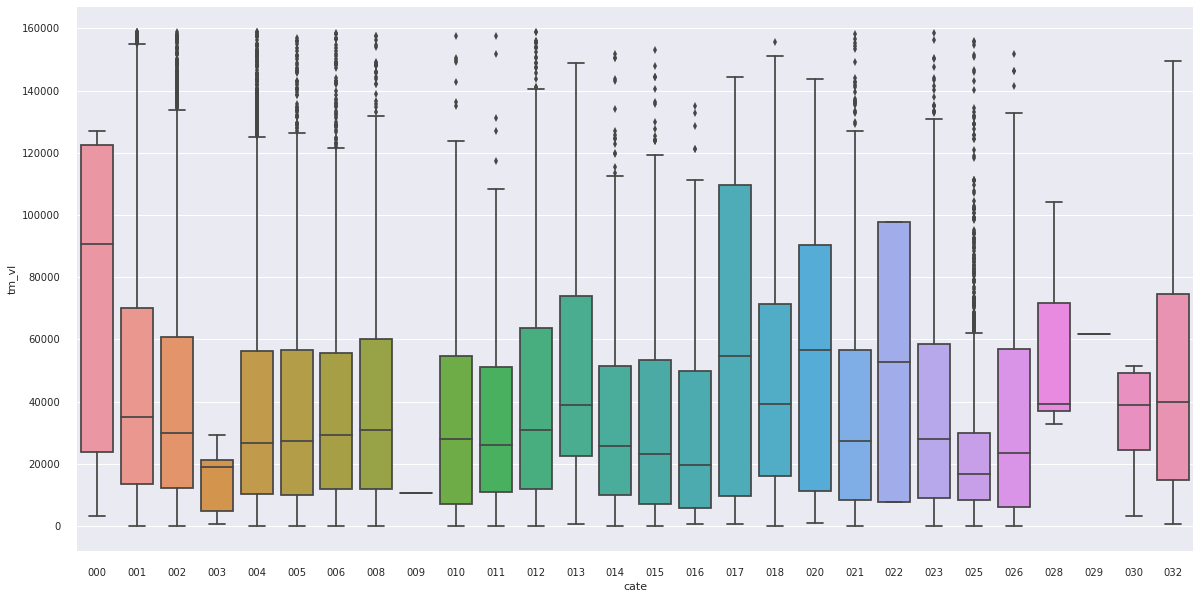

In [28]:
import seaborn as sns

plt.figure(figsize=(20, 10))
# sns.boxplot(x='cate', y='tm_vl', hue='cate', data=dc[dc['cate'].str.len()==3][['cate','tm_vl']], palette="PRGn")
sns.boxplot(x='cate', y='tm_vl', data=dc[dc['cate'].str.len()==3][['cate','tm_vl']])
sns.despine(offset=10, trim=True)
plt.show()

In [ ]:
# ----------- 数据探索 -----------
# utils
def binary_search_range(v, lst, lower, upper):
    mid = int((lower+upper)/2)
    if abs(v-lst[mid])<1e-6:
        return [mid, min(mid+1, len(lst)-1)]
    if lower == upper:
        return [-1, -1]
    if v > lst[mid]:
        lower_nxt = int(mid+1)
        if v < lst[lower_nxt]: return [lower_nxt-1, lower_nxt]
        else: lower = lower_nxt
    if v < lst[mid]:
        upper_nxt = int(mid)
        if v > lst[upper_nxt]: return [upper_nxt, upper_nxt+1]
        else: upper = upper_nxt
    return binary_search_range(v, lst, lower, upper)

def div_bucket(x,dp):
    return [binary_search_range(v, dp, 0, len(dp)-1)[0] for v in x]

def analy_group_corr(data, group, bucket_type='dist', buckets=32):
    pass

def analy_group_corr_duration_ctr_div_bucket(data,group='ds',bucket_type='dist',buckets=32):
    ''' 
    分组阅读时长和ctr相关性分析
    @param group 分组，{ds, item_id, cate}
    @param bucket_type 分桶类型，{dist, freq}
    @param buckets 分桶数
    '''
    ddf = data[[group,'clk','tm_vl']].replace('\\N',{'tm_vl':None})
    ddf['tm_vl'] = ddf['tm_vl'].astype('float')
    dd3_ctr = ddf[[group,'clk']].groupby(ddf[group]).mean() # group平均ctr
    display(dd3_ctr.head(10))
    ddf2 = ddf[(ddf['tm_vl']>0)][[group,'tm_vl']]
    ddf2 = ddf2[ddf2['tm_vl']<ddf2['tm_vl'].quantile(0.95)]
    dd3_tm_vl = ddf2.groupby(ddf2[group]).mean() # group平均阅读时长
    dd3_ctr_tm_vl = dd3_ctr.join(dd3_tm_vl)
    dd3_ctr_tm_vl = dd3_ctr_tm_vl[np.isnan(dd3_ctr_tm_vl['tm_vl'])==False]
    # group ctr和阅读时长相关性
    display(dd3_ctr_tm_vl.corr())
    dd3_ctr_tm_vl.plot(kind='scatter',x='tm_vl',y='clk')
    show()
    # 平均group ctr和平均group阅读时长相关性
    ps = np.linspace(start=0, stop=1, num=33) 
    ef = dd3_ctr_tm_vl['tm_vl'].quantile(ps).values # 等频
    ed = np.linspace(start=dd3_ctr_tm_vl['tm_vl'].min(), stop=dd3_ctr_tm_vl['tm_vl'].max(), num=33) # 等距
    dp = ed if bucket_type=='dist' else ef
    dd3_ctr_tm_vl_grp = dd3_ctr_tm_vl.groupby(div_bucket(dd3_ctr_tm_vl['tm_vl'].values,dp))
    dd3_ctr_tm_vl_mean = dd3_ctr_tm_vl_grp.mean()
    display(dd3_ctr_tm_vl_mean)
    display(dd3_ctr_tm_vl_mean.corr())
    dd3_ctr_tm_vl_mean.plot(kind='scatter', x='clk', y='tm_vl')
    show()
    
# 相关性 - 分类 vs. 阅读时长 
# plt.figure(figsize=(20, 10))
# sns.boxplot(x='cate', y='tm_vl', data=dc[dc['cate'].str.len()==3][['cate','tm_vl']])
# sns.despine(offset=10, trim=True)
dc[dc['cate'].str.len()==3][['cate','tm_vl']].boxplot(column='tm_vl', by='cate', figsize=(15,10))
plt.show()

# 相关性 - 分类 vs. 内容长度分布
# plt.figure(figsize=(20, 10))
# sns.boxplot(x='cate', y='len', data=dc[(dc['cate'].str.len()==3)&(dc['len']<dc['len'].quantile(0.95))][['cate','len']])
# sns.despine(offset=10, trim=True)
dc[(dc['cate'].str.len()==3)&(dc['len']<dc['len'].quantile(0.95))][['cate','len']].boxplot(column='len', by='cate', figsize=(15,10))
plt.show()

# 相关性 - 分类分组，阅读时长和内容长度相关性
# 注：032是纯视频，没有文本内容长度，计算相关性时需要过滤掉
# 结论：呈中等相关性（0.33）
dc_cate_tm_vl_len_mean = dc[(dc['cate'].str.len()==3)&(dc['cate'].str.startswith('032')==False)&(dc['len']<dc['len'].quantile(0.95))][['cate','tm_vl','len']].groupby('cate').mean()
display(dc_cate_tm_vl_len_mean.corr())

# 相关性 - 阅读时长 vs. 内容长度，微观，(reco_id, item_id)分组
display(dc[['tm_vl','len']].corr())

# 相关性 - tm_vl和(td_clk, td_rd, is_rd, len)相关性
# 按tm_vl等频分桶
ps = np.linspace(start=0, stop=1, num=33) 
ef = dc['tm_vl'].quantile(ps).values
dc_grp = dc[['tm_vl','len']].groupby(div_bucket(dc['tm_vl'].values, ef))
dc_mean = dc_grp.mean()
display(dc_mean)
display(dc_mean.corr())
dc_mean.plot(kind='scatter', x='clk', y='tm_vl')
plt.show()

